<a href="https://colab.research.google.com/github/AntoninaKOR/training-code-ml/blob/main/nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Скачивание библиотек

In [ ]:
!pip install seaborn catboost -q
!pip install lightgbm -q
!pip install xgboost -q

#Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats


from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool
from catboost import MetricVisualizer

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Датасеты и переменные result, seed.

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [ ]:
#список с информация о моделях
results=[]

In [ ]:
seed=22

#EDA

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
216,g25517695C,Mercedes-Benz E200,business,petrol,4.36,2014,60420,2020,44.16,engine_overheat,4.170345,1.974305e+07,0.1,188.194555,-5.201434,174,169
1754,r-5783636b,Hyundai Solaris,economy,petrol,4.14,2015,72538,2016,31.90,electro_bug,4.185287,1.007539e+07,0.0,188.000000,8.364877,174,172
1094,F45462936z,Renault Kaptur,standart,petrol,4.30,2013,43308,2014,41.28,engine_overheat,4.223851,1.489955e+07,0.1,193.982146,-10.105778,174,172
2162,E-5860609f,Hyundai Solaris,economy,petrol,4.22,2013,43146,2019,44.09,engine_ignition,4.296092,9.794138e+06,0.1,199.793937,-0.344483,174,174
237,e19460921k,Renault Kaptur,standart,petrol,2.60,2013,37289,2018,26.80,break_bug,5.242471,1.290271e+07,0.1,119.331184,5.782435,174,173
503,u-7756149A,VW Polo VI,economy,petrol,5.08,2013,39926,2017,41.43,engine_overheat,3.862874,1.477935e+07,0.1,177.355750,-0.670958,174,171
431,Q-2037054s,Renault Sandero,standart,petrol,4.90,2014,64792,2016,34.33,gear_stick,4.467011,1.021985e+07,0.1,109.791461,2.236486,174,173
1867,h-1921200Q,Tesla Model 3,premium,electro,4.78,2015,93044,2019,61.19,break_bug,5.255345,1.556993e+07,0.1,105.886396,-6.644752,174,150
2028,b48529290x,VW Polo,economy,petrol,2.90,2013,56221,2014,39.82,break_bug,5.319655,7.117579e+06,0.1,105.921538,21.673724,174,173
763,d21839434m,Kia Rio,economy,petrol,5.00,2015,78693,2021,30.11,electro_bug,4.355632,1.921742e+07,0.0,182.386734,2.903016,174,174


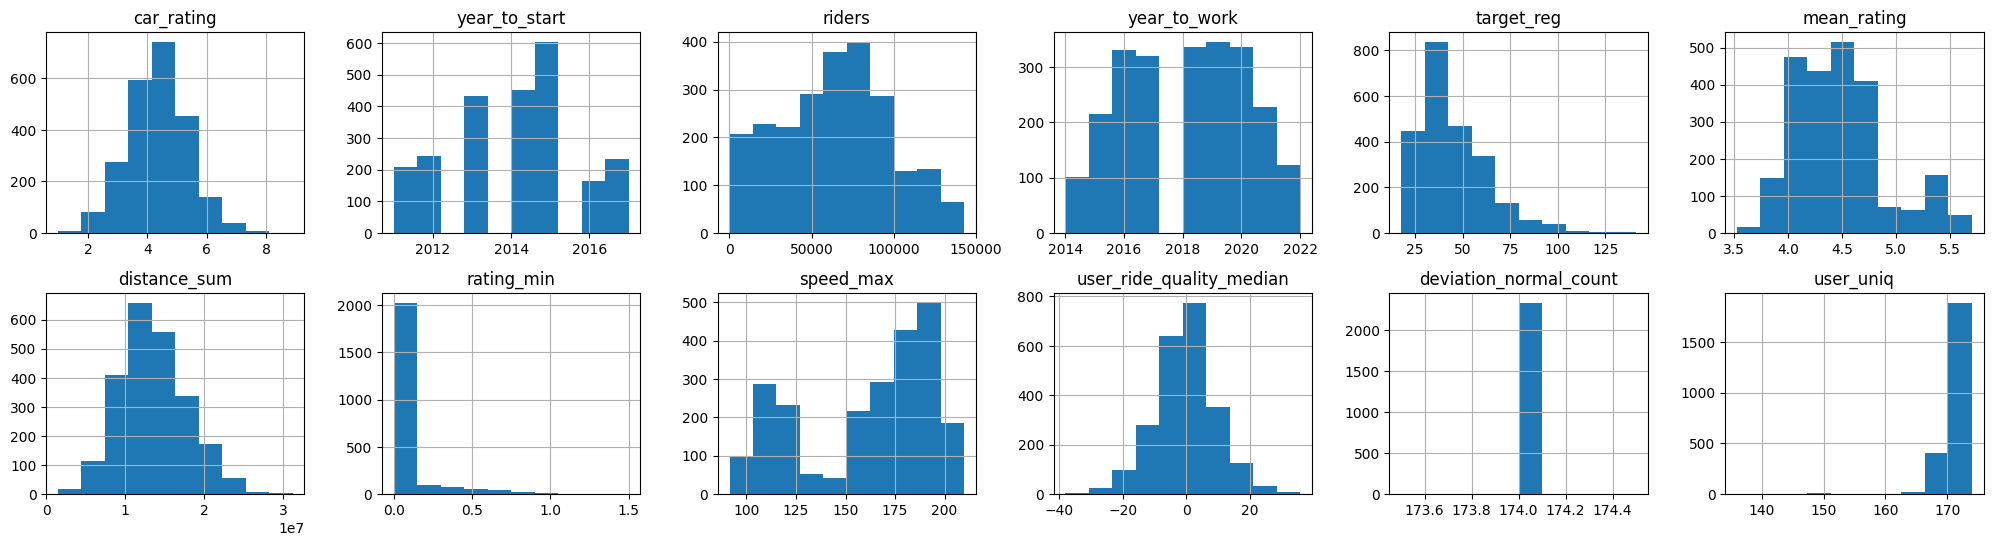

In [ ]:
train.hist(figsize=(25, 6), layout=(-1, 6))
display(train.sample(10))

Кажется, что в колонке deviation_normal_count одно значение и она бесполезная. Проверим это.

In [ ]:
train['deviation_normal_count'].value_counts()

deviation_normal_count
174    2337
Name: count, dtype: int64

#Вспомогательные функции

In [ ]:
def train_model(alg,
                X,
                y,
                early_stopping,
                init_params=None,
                cat_features=None,
                random_seed=22,
                callback=False,
                plot=False,
                train_dir='untuned'):
  scores=[]
  models=[]
  eval_results=[]
  kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)
  print(f"========= TRAINING {alg.__name__} =========")
  for num_fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if init_params is not None:
      model = alg(**init_params)
    else:
      model = alg()
    if alg.__name__=='CatBoostRegressor':
      train_dataset = Pool(X_train, y_train, cat_features=cat_features)
      val_dataset = Pool(X_val, y_val, cat_features=cat_features)
      model.fit(train_dataset, eval_set= val_dataset, early_stopping_rounds= early_stopping, verbose=0)
      y_pred = model.predict(val_dataset)
    elif alg.__name__=='LGBMRegressor':
      eval_result={}
      train_dataset = Dataset(X_train, y_train, categorical_feature=cat_features, free_raw_data=False)
      val_dataset = Dataset(X_val, y_val, categorical_feature=cat_features, free_raw_data=False)
      if (num_fold!=0):
        model = lgb.train(params = init_params,
                  train_set = train_dataset,
                  valid_sets = val_dataset,
                  categorical_feature=cat_features,
                  callbacks=[lgb.reset_parameter(learning_rate=np.linspace(init_params['learning_rate'], 0.07, init_params['num_iterations']).tolist()), lgb.early_stopping(early_stopping), lgb.record_evaluation(eval_result)]      )
      else:
        model = lgb.train(params = init_params,
                  train_set = train_dataset,
                  valid_sets = val_dataset,
                  categorical_feature=cat_features,
                  callbacks=[lgb.early_stopping(early_stopping), lgb.record_evaluation(eval_result)]      )

      eval_results.append(eval_result)
      y_pred = model.predict(X_val)
    else:
      eval_result={}
      train_dataset = xgb.DMatrix(X_train, label=y_train, nthread=-1, enable_categorical=True)
      val_dataset = xgb.DMatrix(X_val, label=y_val, nthread=-1, enable_categorical=True)
      #реализация callback
      if (callback==True):
        n_iters=50
        learning_rates = np.linspace(init_params['eta'],  0.01, init_params['num_boosting_rounds'] ).tolist() # значение lr будет плавно понижаться каждую итерацию с 0.3 до 0.005
        scheduler = xgb.callback.LearningRateScheduler(learning_rates)
        model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (val_dataset, 'dtest')],
                              evals_result = eval_result,
                              verbose_eval=False,
                              callbacks = [scheduler],
                              early_stopping_rounds=early_stopping,

                          )

      else:
        model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (val_dataset, 'dtest')],
                              evals_result = eval_result,
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping)
      eval_results.append(eval_result)
      y_pred = model.predict(val_dataset)

    score = mean_squared_error(y_val, y_pred, squared=False)

    models.append(model)
    scores.append(score)
    print(f'FOLD {num_fold}: SCORE {score}')

  mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
  print("\nMEAN RMSE SCORE", mean_kfold_score)
  best_model = models[np.argmin(scores)]
  return eval_results, mean_kfold_score, best_model

In [ ]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv=3,
                       random_state=22,
    ):

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    return model.best_params_ | init_params

In [ ]:
def val_plot(alg, eval_results):
  sns.set_style("darkgrid")
  if alg.__name__=='LGBMRegressor':
    plot1 = sns.lineplot(x= np.linspace(0, len(eval_results[0]['valid_0']['rmse']), num=len(eval_results[0]['valid_0']['rmse'])), y = eval_results[0]['valid_0']['rmse'], label='FOLD 0')
    plot2 = sns.lineplot(x= np.linspace(0, len(eval_results[1]['valid_0']['rmse']), num=len(eval_results[1]['valid_0']['rmse'])), y = eval_results[1]['valid_0']['rmse'], label='FOLD 1')
    plot3 = sns.lineplot(x= np.linspace(0, len(eval_results[2]['valid_0']['rmse']), num=len(eval_results[2]['valid_0']['rmse'])), y = eval_results[2]['valid_0']['rmse'], label='FOLD 2')
    plot1.set(xlabel='iters', ylabel='rmse')
  else:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    axes[0].set_title('FOLD 0')
    plot0_val = sns.lineplot(x= np.linspace(0, len(eval_results[0]['dtest']['rmse']), num=len(eval_results[0]['dtest']['rmse'])), y = eval_results[0]['dtest']['rmse'], label='val', ax=axes[0] )
    plot0_train = sns.lineplot(x= np.linspace(0, len(eval_results[0]['dtrain']['rmse']), num=len(eval_results[0]['dtrain']['rmse'])), y = eval_results[0]['dtrain']['rmse'], label='train', ax=axes[0] )

    axes[1].set_title('FOLD 1')
    plot1_val = sns.lineplot(x= np.linspace(0, len(eval_results[1]['dtest']['rmse']), num=len(eval_results[1]['dtest']['rmse'])), y = eval_results[1]['dtest']['rmse'], label='val', ax=axes[1] )
    plot1_train = sns.lineplot(x= np.linspace(0, len(eval_results[1]['dtrain']['rmse']), num=len(eval_results[1]['dtrain']['rmse'])), y = eval_results[1]['dtrain']['rmse'], label='train', ax=axes[1] )

    axes[2].set_title('FOLD 2')
    plot0_val = sns.lineplot(x= np.linspace(0, len(eval_results[2]['dtest']['rmse']), num=len(eval_results[2]['dtest']['rmse'])), y = eval_results[2]['dtest']['rmse'], label='val', ax=axes[2] )
    plot0_train = sns.lineplot(x= np.linspace(0, len(eval_results[2]['dtrain']['rmse']), num=len(eval_results[2]['dtrain']['rmse'])), y = eval_results[2]['dtrain']['rmse'], label='train', ax=axes[2] )

  plt.show()

#Группируем признаки

In [ ]:
cat_features = ['model',	'car_type',	'fuel_type']
targets = ['target_reg', 'target_class']
#индекс удаляем тк он не несет смысла,  deviation_normal_count, тк оно принимает одно значения на всем датасете
features2drop = ['car_id', 'deviation_normal_count']
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

In [ ]:
X = train[filtered_features]
y = train["target_reg"]

#CatBoost

In [ ]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': seed,
    'train_dir': 'untuned'
}

_, cb_score, cb_model = train_model(
    alg=CatBoostRegressor,
    X=X, y=y,
    init_params=cb_init_params,
    early_stopping=20,
    cat_features=cat_features,
    random_seed=seed,
    plot=True
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.188535103807729
FOLD 1: SCORE 11.589942588004694
FOLD 2: SCORE 11.843976325432818

MEAN RMSE SCORE 11.266


In [ ]:
cb_test_pred = cb_model.predict(test[filtered_features])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred.csv', index=False)

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'kfold_score': cb_score,
    'kfold_score': cb_score,
    'model': cb_model
})

In [ ]:
#на лидерборде 12.1

##Тюнинг

In [ ]:
cb_init_tuned_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': seed,
    'train_dir': 'tuned'
}

cb_fit_params = {
    'cat_features': cat_features,
    'verbose': 0,
    'early_stopping_rounds': 20,
}


# Параметры, которые будем перебирать
cb_grid_params = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}


catboost_params_after_tuning = tuning_hyperparams(algorithm=CatBoostRegressor,
                                                  X=X, y=y,
                                                  init_params=cb_init_params,
                                                  fit_params=cb_fit_params,
                                                  grid_params=cb_grid_params,
                                                  n_iter=20,
                                                  random_state=seed
)

catboost_params_after_tuning

{'depth': 3,
 'l2_leaf_reg': 2,
 'learning_rate': 0.03,
 'one_hot_max_size': 2,
 'loss_function': 'RMSE',
 'eval_metric': 'RMSE',
 'thread_count': -1,
 'task_type': 'CPU',
 'random_seed': 22,
 'train_dir': 'untuned'}

In [ ]:
_, cb_tuning_score, cb_tuning_model = train_model(alg=CatBoostRegressor,
                                               X=X, y=y,
                                               early_stopping=20,
                                               init_params=catboost_params_after_tuning,
                                               cat_features=cat_features,
                                               random_seed=seed)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.275508876501839
FOLD 1: SCORE 11.710893754600402
FOLD 2: SCORE 11.841094046103894

MEAN RMSE SCORE 11.36


In [ ]:
tuning_cb_test_pred = cb_tuning_model.predict(test[filtered_features])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_cb_test_pred}).to_csv('tuning_cb_pred.csv', index=False)

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'mean_kfold_score': cb_tuning_score,
    'model': cb_tuning_model
})

In [ ]:
#на лидерборде 11.9

#LightGBM

In [ ]:
X_lgb = X.copy()

le = LabelEncoder()
for col in cat_features:
    X_lgb[col] = le.fit_transform(X_lgb[col])

In [ ]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'rmse',
    'objective': 'regression',
    'random_state': seed,
    'verbosity': -1,
    'device': 'cpu',
    'data_sample_strategy':'goss',
    'early_stopping_min_delta': 0.001,
    'learning_rate':0.1,
    'num_iterations':100
}


eval_result, lgb_score, lgb_model = train_model(
    alg=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_init_params,
    early_stopping=5,
    cat_features=cat_features,
    random_seed=seed
)

========= TRAINING LGBMRegressor =========
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 11.7148
FOLD 0: SCORE 11.714795863879717
Training until validation scores don't improve for 5 rounds
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] No further sp

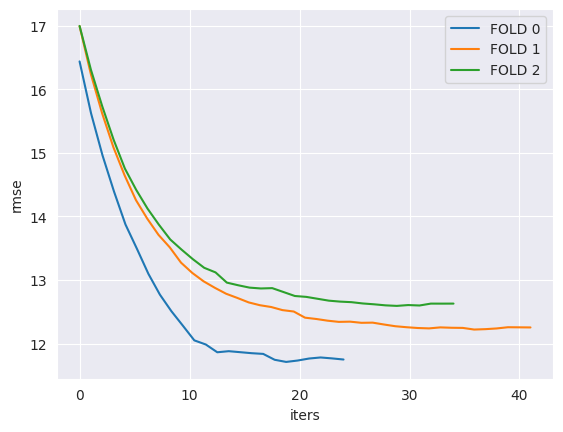

In [ ]:
#график обучения
val_plot(LGBMRegressor, eval_result)

Заметим, что график при Fold 0 слишком резкий попробуем это исправить.

In [ ]:
#обрабатываем кат. фичи в тесте
test_encoded = test.copy()
le = LabelEncoder()
for col in cat_features:
    test_encoded[col] = le.fit_transform(test_encoded[col])
lgb_test_pred = lgb_model.predict(test_encoded[filtered_features], num_iteration =lgb_model.best_iteration )

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred.csv', index=False)

In [ ]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': False,
    'mean_kfold_score': lgb_score,
    'model': lgb_model
})

In [ ]:
#в лидерборде 12.4

In [ ]:
lgb_model.params

{'boosting_type': 'goss',
 'n_jobs': -1,
 'metric': 'rmse',
 'objective': 'regression',
 'random_state': 22,
 'verbosity': -1,
 'device': 'cpu',
 'data_sample_strategy': 'goss',
 'early_stopping_min_delta': 0.001,
 'learning_rate': 0.1,
 'num_iterations': 100,
 'categorical_column': [0, 1, 2]}

Посмотрим на важные фичи

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

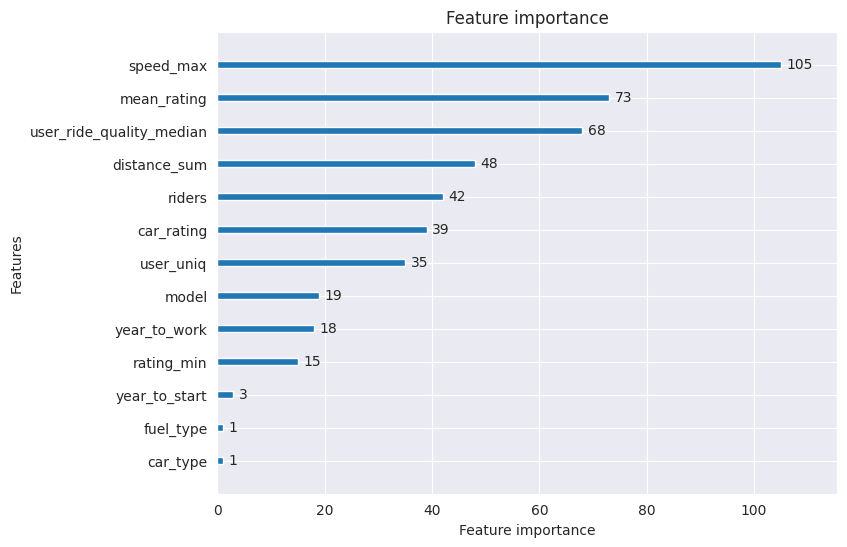

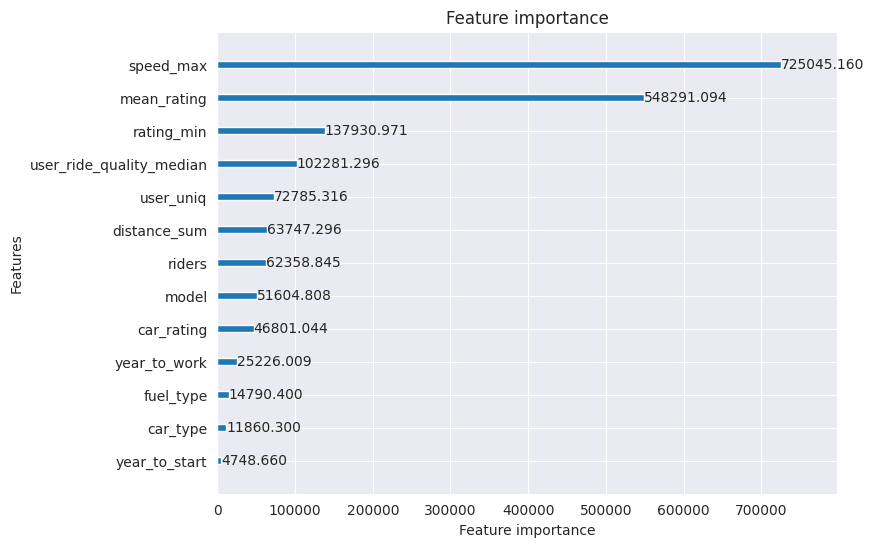

In [ ]:
lgb.plot_importance(lgb_model, figsize=(8, 6), importance_type="split")
lgb.plot_importance(lgb_model, figsize=(8, 6), importance_type="gain")

##Тюнинг

In [ ]:
cat_features_tune = ['model', 'fuel_type']
drop_col = ['car_type' ]

lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'rmse',
    'objective': 'regression',
    'random_state': seed,
    'verbosity': -1,
    'verbose_eval':-1,
    'device': 'cpu',
    'data_sample_strategy':'goss',
    'early_stopping_min_delta': 0.001
}



lgb_fit_params = {
    'eval_metric': 'rmse',
    'categorical_feature': cat_features_tune
}


lgb_grid_params = {
    #на этих параметрах остановились после поиска
    "learning_rate": [0.03, 0.02],
    'num_iterations':[200],
    'num_leaves':[  5],
    'min_data_in_leaf': [10],
    'bagging_fraction': [1.0],
    'feature_fraction': [0.8],

    #'max_bin': [50, 100, 200]
    #'reg_lambda': [0, 0.5, 1]
    #'bagging_freq': [5, 7, 4],
    #'bagging_fraction': [0.7, 1., 0.5],
    #'max_bin': [ 250, 240]
    #'lambda_l1': [ 0.9],
    #'lambda_l2': [0.9]
}


lgb_params_after_tuning = tuning_hyperparams(algorithm=LGBMRegressor,
                                             X=X_lgb.drop(drop_col, axis=1), y=y,
                                             init_params=lgb_init_params,
                                             fit_params=lgb_fit_params,
                                             grid_params=lgb_grid_params,
                                             n_iter=10,
                                             random_state=seed
)

lgb_params_after_tuning

{'num_leaves': 5,
 'num_iterations': 200,
 'min_data_in_leaf': 10,
 'learning_rate': 0.03,
 'feature_fraction': 0.8,
 'bagging_fraction': 1.0,
 'boosting_type': 'goss',
 'n_jobs': -1,
 'metric': 'rmse',
 'objective': 'regression',
 'random_state': 22,
 'verbosity': -1,
 'verbose_eval': -1,
 'device': 'cpu',
 'data_sample_strategy': 'goss',
 'early_stopping_min_delta': 0.001}

In [ ]:
eval_tuned_result, lgb_tuning_score, lgb_tuning_model = train_model(
    alg=LGBMRegressor,
    X=X_lgb.drop(drop_col, axis=1), y=y,
    init_params=lgb_params_after_tuning,
    cat_features=cat_features_tune,
    early_stopping = 20,
    random_seed=seed
)

========= TRAINING LGBMRegressor =========
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 11.2424
FOLD 0: SCORE 11.2423826076434
Training until validation scores don't improve for 20 rounds
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[

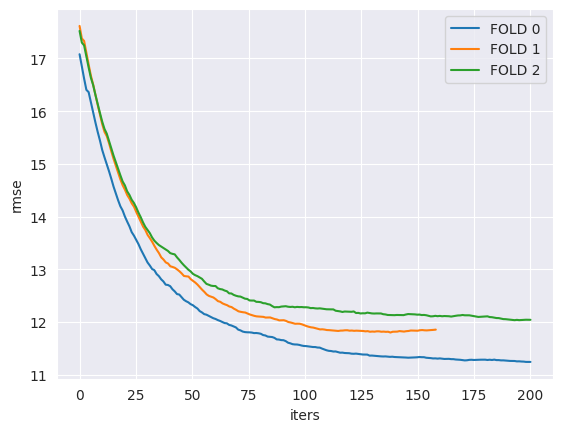

In [ ]:
val_plot(LGBMRegressor, eval_tuned_result)

График fold 0 стал более градким. У остальных фолдов повысилась точность.

In [ ]:
tuning_lgb_test_pred = lgb_tuning_model.predict(test_encoded[filtered_features].drop(drop_col, axis=1))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_lgb_test_pred}).to_csv('tuning_lgb_pred.csv', index=False)

В лидерборде результат выдает 12.0, это на 0.1 хуже чет catboost с подобранными параметрами при том, что при валидации обе модели выдают одинаковую точность.

In [ ]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': True,
    'mean_kfold_score': lgb_tuning_score,
    'model': lgb_tuning_model
})

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

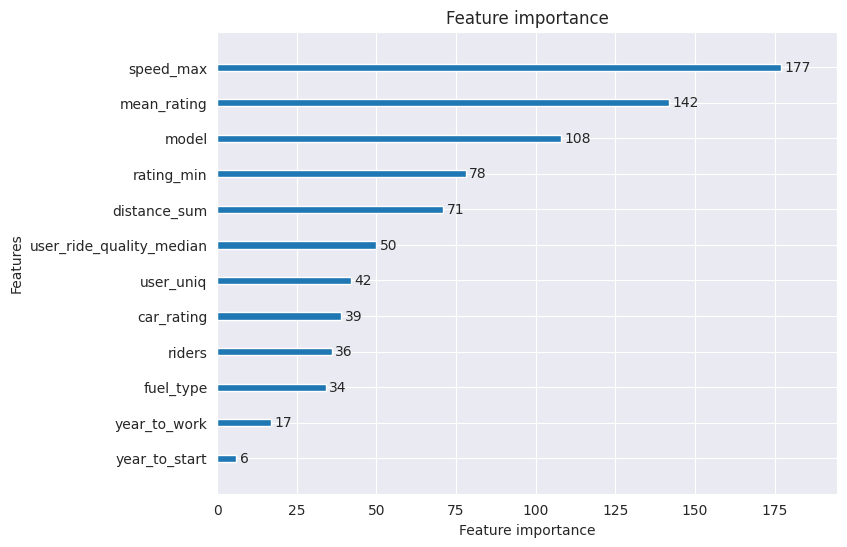

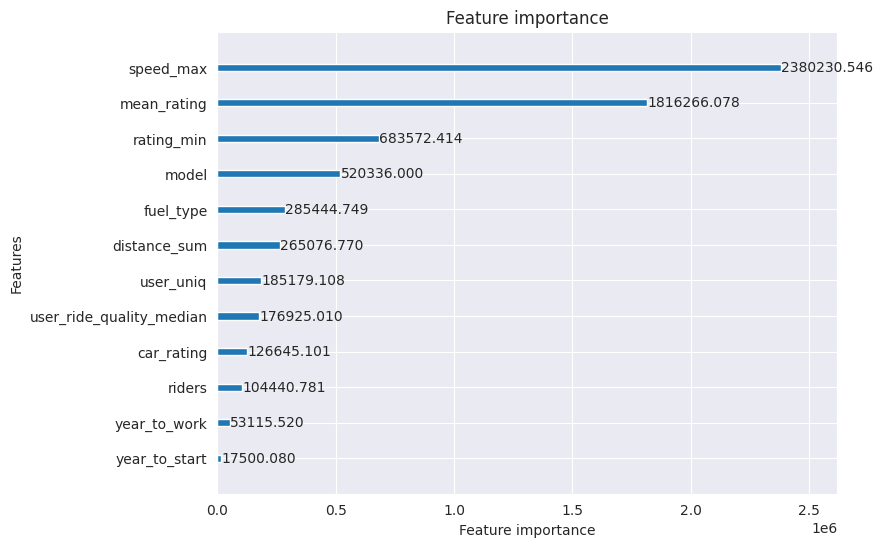

In [ ]:
lgb.plot_importance(lgb_tuning_model, figsize=(8, 6), importance_type="split")
lgb.plot_importance(lgb_tuning_model, figsize=(8, 6), importance_type="gain")

Заметим, что у нас по-прежнему есть  фичи, которые кажутся мусорными, но попытки  их выкинуть и подобать параметры не привели к успеху.Но при их отбразывание, модель на fold 0 показывает меньшую точность, так что скорее всего она учится на мусоре.

#XGB

In [ ]:
X_xgb = X.copy()
for col in cat_features:
    X_xgb[col] = X_xgb[col].astype('category')

#обработка тестовых данных
test_xgb=test[filtered_features].copy()
for col in cat_features:
    test_xgb[col] = test_xgb[col].astype('category')
test_xgb = xgb.DMatrix(test_xgb, nthread=-1, enable_categorical=True)

In [ ]:
xgb_init_params = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': seed,
    'n_jobs': -1,
    'verbosity': 0,
    'rate_drop': 0.4,
    'one_drop': 1
}


eval_resul_xgb, xgb_score, xgb_model = train_model(
    alg=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_init_params,
    early_stopping=20,
    cat_features=cat_features,
    random_seed=seed
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 11.81203269101075
FOLD 1: SCORE 12.418205029258324
FOLD 2: SCORE 12.602328901120922

MEAN RMSE SCORE 11.945


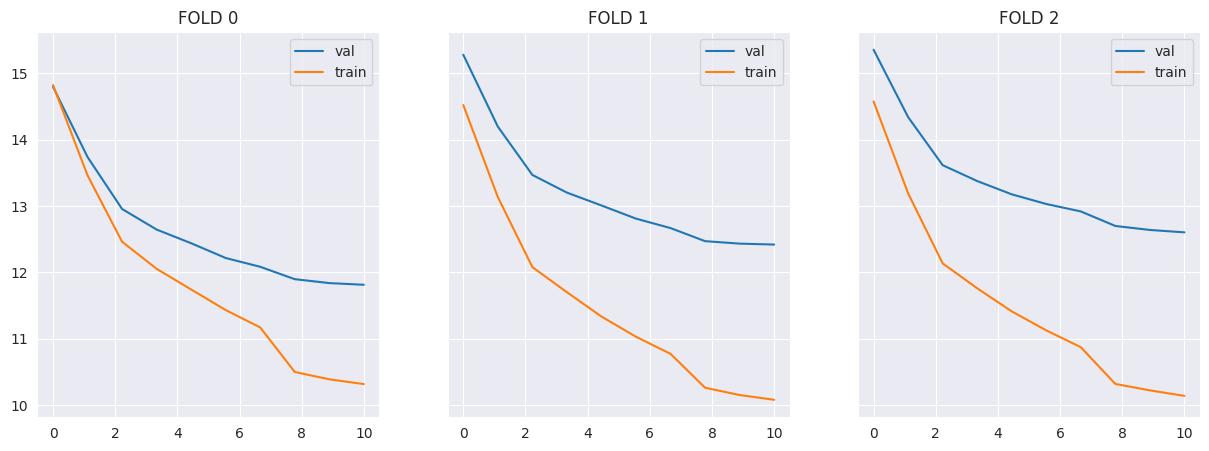

In [ ]:
val_plot(XGBRegressor, eval_resul_xgb )

Видим, что модель еще недообучилась.

In [ ]:
xgb_test_pred = xgb_model.predict(test_xgb, iteration_range=(0, xgb_model.best_iteration + 1))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('xgb_pred.csv', index=False)

In [ ]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': False,
    'mean_kfold_score': xgb_score,
    'model': xgb_model
})

На лидерборде результат 12.5

##Тюнинг

In [ ]:
cat_features_tune = ['model', 'fuel_type', 'car_type']
drop_col = [ ]
xgb_init_params_tune = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': seed,
    'n_jobs': -1,
    'verbosity': 0,
    'one_drop': 1,
    'verbose_eval':0,
    'num_boosting_rounds':1000,
    'eta': 0.5

}

xgb_grid_params = {
    'max_depth': [3, 5],
    'max_leaves': [7, 9],
    'min_child_weight': [12, 14],
    #'colsample_bytree':[0.3, 0.5, 1],
    #'subsample':[0.3, 0.5, 0.8, 0.7],
    'rate_drop':[0.1, 0.3, 0.05],
    #'normalize_type': ['tree', 'forest']
    #'lambda':[1, 2, 4],
    #'gamma':[1, 2, 0.3],
    #'alpha':[1, 2, 4]

}


xgb_fit_params = {
    'verbose': False
}


xgb_params_after_tuning = tuning_hyperparams(algorithm=XGBRegressor,
                                             X=X_xgb.drop(drop_col, axis=1), y=y,
                                             init_params=xgb_init_params_tune,
                                             fit_params=xgb_fit_params,
                                             grid_params=xgb_grid_params,
                                             n_iter=30,
                                             cv=3,
                                             random_state=seed
)

xgb_params_after_tuning

{'rate_drop': 0.1,
 'min_child_weight': 14,
 'max_leaves': 9,
 'max_depth': 5,
 'enable_categorical': True,
 'booster': 'dart',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 22,
 'n_jobs': -1,
 'verbosity': 0,
 'one_drop': 1,
 'verbose_eval': 0,
 'num_boosting_rounds': 1000,
 'eta': 0.5}

In [ ]:
xgb_eval_tune_result, xgb_tuning_score, xgb_tuning_model = train_model(
    alg=XGBRegressor,
    X=X_xgb.drop(drop_col, axis=1), y=y,
    init_params=xgb_params_after_tuning,
    early_stopping=20,
    cat_features=cat_features_tune,
    random_seed=seed,
    callback=True
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 11.3978663866089
FOLD 1: SCORE 12.101416933133605
FOLD 2: SCORE 12.1732404291372

MEAN RMSE SCORE 11.55


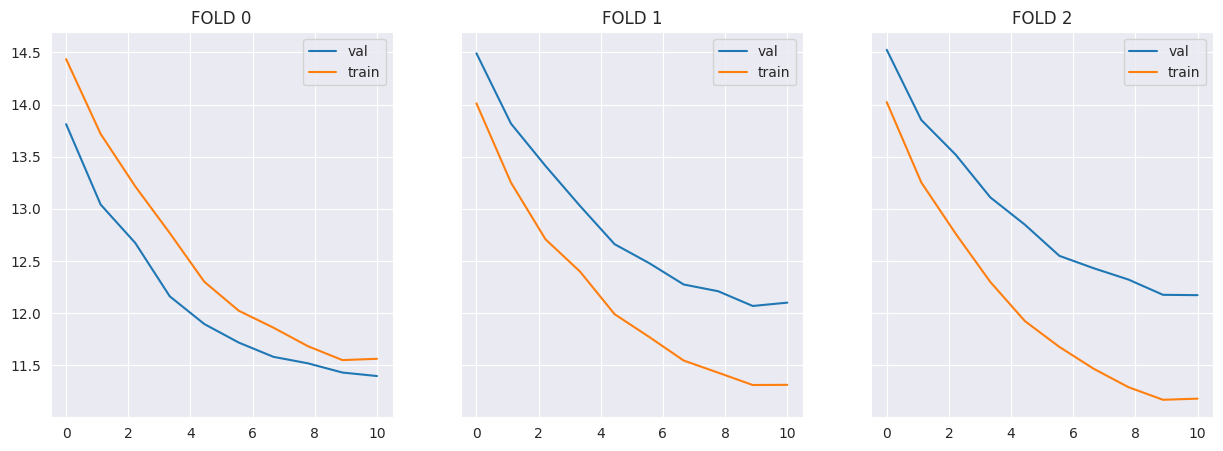

In [ ]:
val_plot(XGBRegressor, xgb_eval_tune_result)

In [ ]:
test_xgb_tune=test[filtered_features].copy()
test_xgb_tune.drop(drop_col, axis=1, inplace=True)
for col in cat_features_tune:
    test_xgb_tune[col] = test_xgb_tune[col].astype('category')
test_xgb_tune = xgb.DMatrix(test_xgb_tune, nthread=-1, enable_categorical=True)
tuning_xgb_test_pred = xgb_tuning_model.predict(test_xgb_tune, iteration_range=(0, xgb_tuning_model.best_iteration + 1))


pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_xgb_test_pred}).to_csv('tuning_xgb_pred.csv', index=False)

In [ ]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': True,
    'mean_kfold_score': xgb_tuning_score,
    'model': xgb_tuning_model
})

#Обобщение результатов

In [ ]:
best_cb_model = cb_tuning_model
best_cb_model.save_model('best_cb_model.cbm')

best_lgb_model = lgb_tuning_model
best_lgb_model.save_model('best_lgb_model.mod')


best_xgb_model =  xgb_tuning_model
best_xgb_model.save_model('best_xgb_model.json')

In [ ]:
final_cb_pred = tuning_cb_test_pred
final_lgb_pred =  tuning_lgb_test_pred
final_xgb_pred =tuning_xgb_test_pred

final_pred = 1./3.*(final_cb_pred+final_lgb_pred+final_xgb_pred)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': final_pred}).to_csv('final_submission.csv', index=False)

#Вывод

Лучше всего себя показал Catboost, который даже без подбора гиперпараметров выдавал в лидерборде 12.1, а после - 11.9.

Благодаря Feature Importance получилось без потери точности убрать столбец car_type, что ускорило обучение, но гиперпараметры потребовались новые.


Также благодаря графикам обучения моделей получилось лучше отследить переобучение моделий.

Коллбаки и шедулеры помогли повысить точности LightGBM и XGB.

Финальный результат дал точность 11.9 на лидерборде.